# A sinusoidal weight matrix is most robust to noise

* If we want a circulant network to have stable activity with no input
* and the network is operating in the linear regime
* and the network needs to encode 2 variables (vector direction and magnitude)
* and the neurons can have negative activities (we consider activity is being relative to some baseline firing)

Then the solution which provides the optimal noise resilience is:
* the activity is a sinusoid with period equal to the number of neurons, and 0 mean
* the weight matrix is a also a sinusoid with zero mean (ie. only Fourier mode 1 is non-zero)

Results:
* increasing the number of Fourier modes present in the weight matrix after the first 1 (which is required) increases the resulting noise linearly
  * only having Fourier mode 1 allows the weight matrix to perform band pass filtering on the noise and reject most of it
* increasing the number of neurons in the network allows for better noise rejection as this band pass filter narrows

Note:
* using the first harmonic ($f = \frac{2}{N}$) instead of the fundamental frequency would perform equally well to the base sinusoid in terms of noise robustness

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg
plt.style.use('seaborn-v0_8-notebook')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)

%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
N = 8
neuron_indices = np.arange(N)
scaled_cosine = lambda neuron_indices, N: (1 + np.cos(2*np.pi*neuron_indices/N))/2
scaled_cosine_zero_mean = lambda neuron_indices, N: np.cos(2*np.pi*neuron_indices/N)/2
gaussian = lambda neuron_indices, N: np.exp(-(neuron_indices - N/2)**2 /4)

profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

def fill_fourier_modes_in_range(first_fourier_mode:int, last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements between `first_fourier_mode` and `last_fourier_mode` (inclusive) filled with ones, with other Fourier modes = 0.
	
	eg. `fill_fourier_modes_in_range(1, 2, 4) = [0,1,1,1]`
	'''
	fourier_spectrum = (fill_fourier_modes_up_to_N(last_fourier_mode, period) - fill_fourier_modes_up_to_N(first_fourier_mode-1, period))
	return fourier_spectrum

a = scaled_cosine_zero_mean(neuron_indices, N)

In [3]:
def simulate_and_plot(a0, W, dt=0.001, repetitions=100, noise=0.3, plot=True, show=True):
	a = np.tile(a0, (repetitions,1)).T
	a += noise*np.random.randn(*a.shape)

	# simulate for 50000 time steps
	for _ in range(50000):
		delta_a = -a + W@a
		a += dt*delta_a
		if abs(delta_a).sum() < 1e-6:
			break

	error = a - a0.reshape(a0.size,1)
	mu = a.mean(axis=1)
	stdev = np.sqrt(a.var(axis=1))
	ms_error = np.mean(error**2, axis=0)
	ms_mean = ms_error.mean()
	ms_stdev = ms_error.std()
	assert mu.size == a0.size and stdev.size == a0.size, 'Not averaging over repetitions in the right direction'
	assert ms_error.size == repetitions, 'Not averaging over neurons in the right direction'

	if plot:
		plt.fill_between(neuron_indices, mu - stdev, mu + stdev, alpha=0.5, label='response stddev')
		plt.plot(neuron_indices, a[:,0], 'orange', label='example response')
		plt.plot(a0, 'k', label='original activity')
		plt.title(f'Average noise variance = {ms_mean:.4f}$\\pm${ms_stdev:.4f}')
		plt.legend()
		if show:
			plt.show()

	return ms_mean, ms_stdev

## Test how adding more Fourier modes effects the error

Fourier modes up to 1 = [0. 1. 0. 0. 0. 0. 0. 1.]


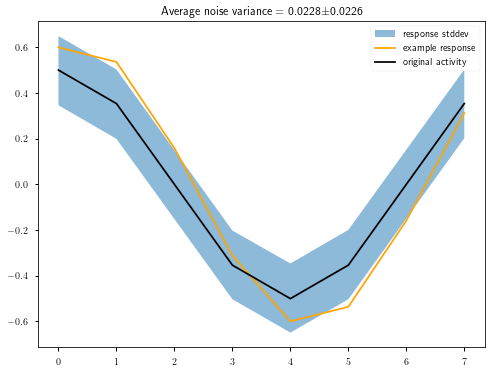

Fourier modes up to 2 = [0. 1. 1. 0. 0. 0. 1. 1.]


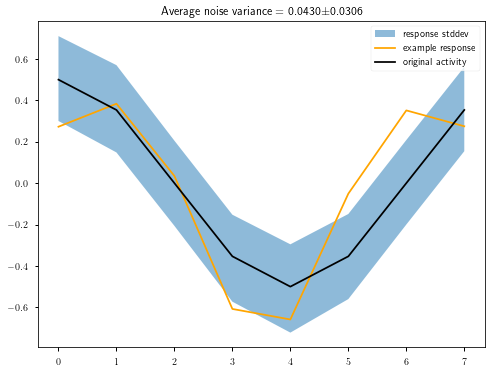

Fourier modes up to 3 = [0. 1. 1. 1. 0. 1. 1. 1.]


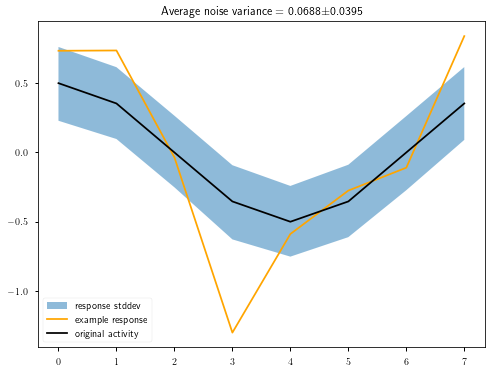

Fourier modes up to 4 = [0. 1. 1. 1. 1. 1. 1. 1.]


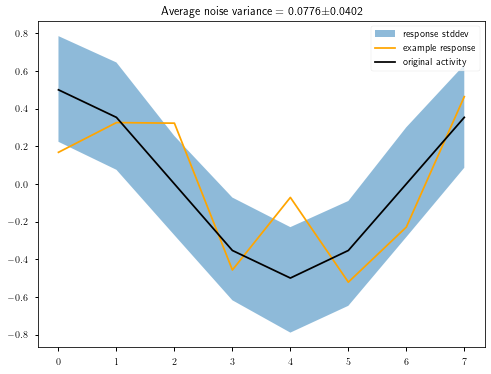

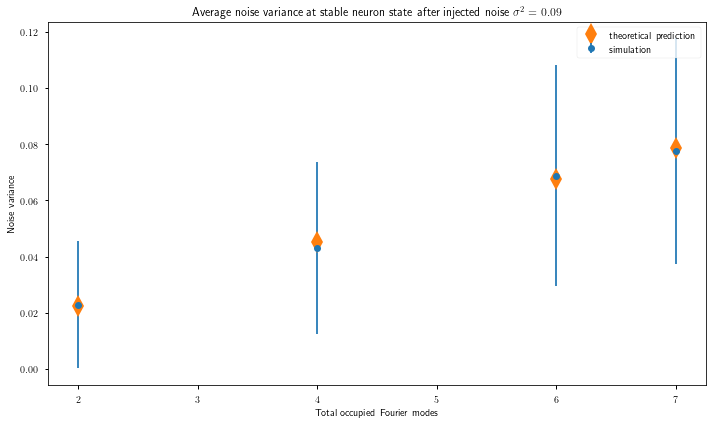

In [4]:
fourier_mode_errors = []
fourier_mode_stddevs = []
fourier_modes = []
noise_stddev = 0.3
noise_var = noise_stddev**2

last_mode_range = np.arange(1,N//2+1,1)
for last_mode in last_mode_range:
	fw = fill_fourier_modes_in_range(1, last_mode, N)

	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

	print(f'Fourier modes up to {last_mode} = {fw}')
	ms_mean, ms_stddev = simulate_and_plot(a, W, noise=noise_stddev, repetitions=1000)
	fourier_mode_errors.append(ms_mean)
	fourier_mode_stddevs.append(ms_stddev)
	fourier_modes.append(fw.sum())
plt.figure(figsize=(10,6))
plt.errorbar(fourier_modes, fourier_mode_errors, fourier_mode_stddevs, fmt='o', label='simulation')
plt.plot(fourier_modes, [noise_var/N*np.sum(fill_fourier_modes_in_range(1, last_mode, N)) for last_mode in last_mode_range], 'd', markersize=15, label='theoretical prediction')
plt.xlabel('Total occupied Fourier modes')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.legend()
plt.tight_layout()
plt.show()

The noise variance increases linearly with the number of extra Fourier modes, as predicted

$$\textbf{Var}\left[||\omega \ast e||^2\right] = \frac{1}{N}||\omega||^2 \textbf{E}\left[||\epsilon||^2\right] = \frac{1}{N}\sum_f||\mathcal{F}_f[\omega]||^2 \textbf{E}\left[||\epsilon||^2\right]$$

In [5]:
dt=0.001

noisy_activity = a + noise_stddev*np.random.randn(*a.shape)

circular_concat = lambda x : np.hstack((x, x[0]))

W_fs = []
a_fs = []

for final_mode in range(1,5):
	W_f = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(1, final_mode, N)))
	a_f = noisy_activity.copy()

	for _ in range(50000):
		a_f += dt*(W_f@a_f - a_f)

	W_fs.append(W_f)
	a_fs.append(a_f)

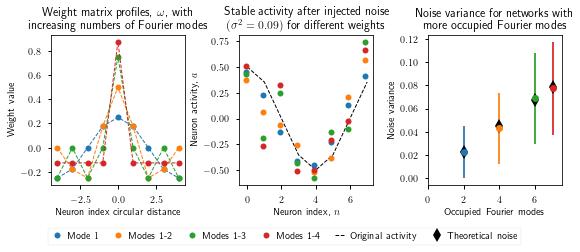

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(8,3.5))
axs[1].plot(neuron_indices, a, 'k--', linewidth=1, label='Original activity')

for final_mode, a_f, W_f in zip(range(1,5), a_fs, W_fs):
	axs[0].plot(np.arange(-N//2,N//2+1), circular_concat(W_f[N//2,:]), label=f'Modes 1-{final_mode}' if final_mode > 1 else 'Mode $1$', marker='o', markersize=6, linestyle='--', linewidth=1)
	axs[1].plot(neuron_indices-0.1, a_f, 'o', label=f'Modes 1-{final_mode}' if final_mode > 1 else 'Mode $1$', markersize=6)

axs[0].set_xlabel('Neuron index circular distance')
axs[0].set_ylabel('Weight value')
axs[0].set_title('Weight matrix profiles, $\\omega$, with\nincreasing numbers of Fourier modes')
# axs[0].set_ylim(-0.3,1.5)
# axs[0].legend()

axs[1].set_xlabel('Neuron index, $n$')
axs[1].set_ylabel('Neuron activity, $a$')
axs[1].set_title(f'Stable activity after injected noise\n$(\\sigma^2={noise_var})$ for different weights')
# axs[1].set_ylim(-0.8,2.1)
# axs[1].legend()

for mode, (fourier_mode, fourier_mode_error, fourier_mode_stddev) in enumerate(zip(fourier_modes, fourier_mode_errors, fourier_mode_stddevs)):
	axs[2].errorbar(fourier_mode, fourier_mode_error, fourier_mode_stddev, fmt='o', label=f'Modes 1-{mode+1}' if mode > 0 else 'Mode $1$')
axs[2].plot(fourier_modes, noise_var/N*np.array(fourier_modes), 'kd', markersize=10, label='Theoretical noise')
axs[2].set_xlabel('Occupied Fourier modes')
axs[2].set_ylabel('Noise variance')
axs[2].set_title(f'Noise variance for networks with\nmore occupied Fourier modes')
axs[2].set_xlim(0,N-0.5)
# axs[2].set_ylim(-0.01,0.3)
# axs[2].legend()

ax1_handles, ax1_labels = axs[1].get_legend_handles_labels()
ax2_handles, ax2_labels = axs[2].get_legend_handles_labels()
handles = ax1_handles[1:] + [ax1_handles[0], ax2_handles[0]]
labels = ax1_labels[1:] + [ax1_labels[0], ax2_labels[0]]
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=6, handlelength=1, handletextpad=0.5, columnspacing=1.5)
bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(fig.transFigure.inverted())
plt.tight_layout(rect=(0, bbox.y1, 1, 1))
plt.savefig('plots/sinusoidal-noise-rejection-fourier-modes-negative-activity.pdf')
plt.show()

## Test how increasing the number of neurons decreases the error

N = 4


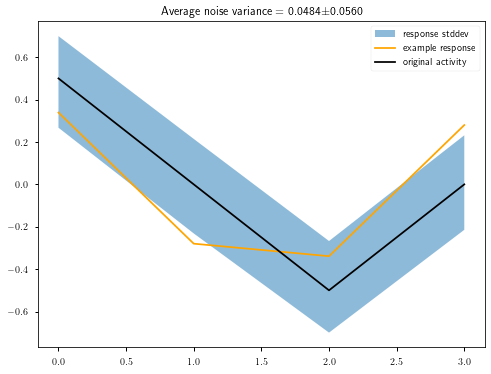

N = 8


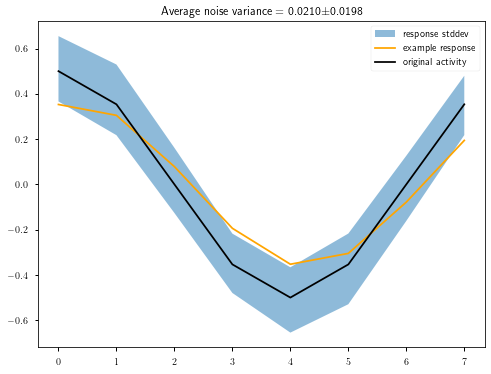

N = 16


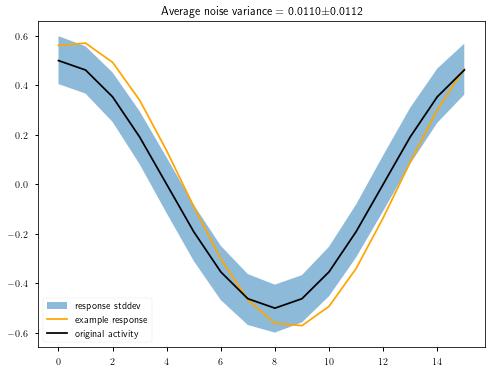

N = 32


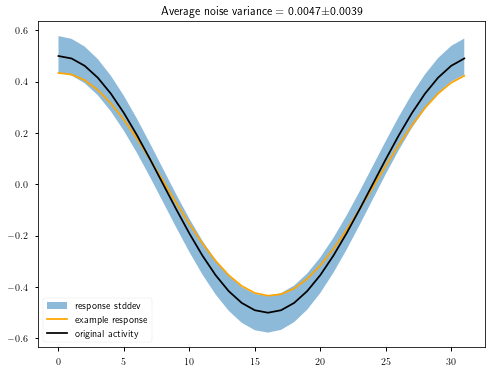

N = 64


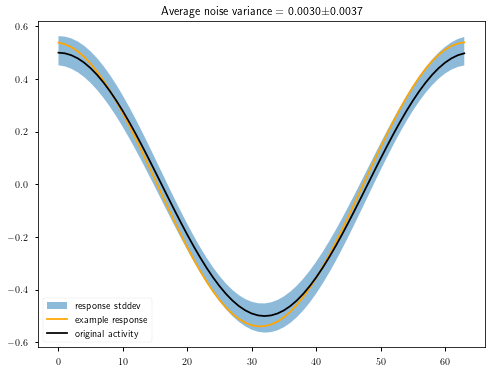

N = 128


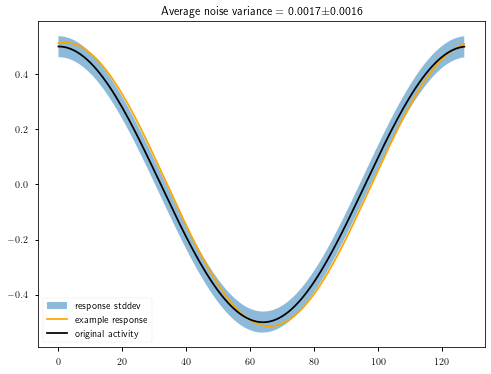

N = 256


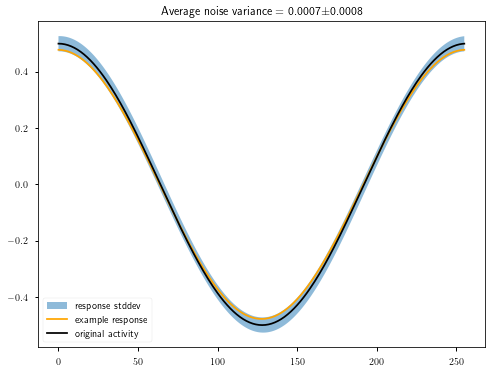

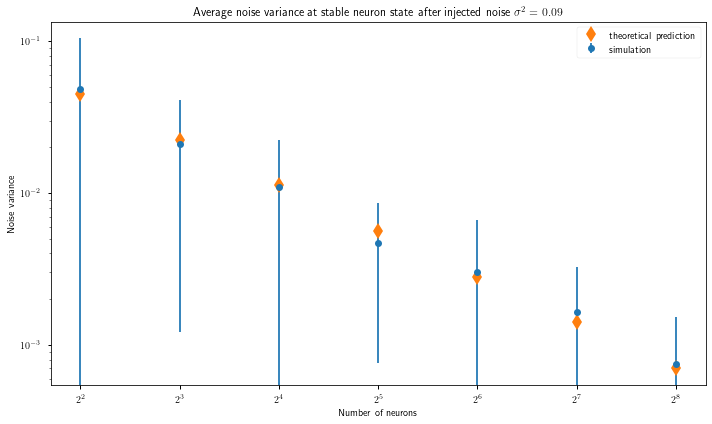

In [8]:
# test for the size of the network
num_neurons_errors = []
num_neurons_stddevs = []

N_range = (2**np.arange(2,9)).astype(np.uint32)
for n in N_range:
	fw = fill_fourier_modes_in_range(1, 1, n)
	neuron_indices = np.arange(n)
	a = scaled_cosine_zero_mean(neuron_indices, n)

	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

	print(f'N = {n}')
	ms_mean, ms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
	num_neurons_errors.append(ms_mean)
	num_neurons_stddevs.append(ms_stddev)
plt.figure(figsize=(10,6))
plt.errorbar(N_range, num_neurons_errors, num_neurons_stddevs, fmt='o', label='simulation')
plt.plot(N_range, noise_var*2/N_range, 'd', markersize=12, label='theoretical prediction')
plt.xlabel('Number of neurons')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.xscale('log', base=2)
plt.yscale('log', base=10)
plt.legend()
plt.tight_layout()
plt.savefig('plots/sinusoidal-noise-rejection-number-neurons-negative-activity.pdf')
plt.show()

The log of the variance decreases linearly with the log of the number of neurons. Ie. the noise variance decreases inversely proportionally to the number of neurons, as predicted.

Here we always fill fourier mode 1 - ie. 2 elements in the Fourier spectrum ($+f, -f$) so the expected variance is $2/N$ of the injected noise variance.

$$\textbf{Var}\left[||\omega \ast e||^2\right] = \frac{2}{N} \textbf{E}\left[||\epsilon||^2\right]$$

## Test using the second Fourier mode

In [9]:
a2 = scaled_cosine_zero_mean(neuron_indices*2, N)

fourier_mode_errors = []
fourier_mode_stddevs = []
fourier_modes = []
noise_stddev = 0.3
noise_var = noise_stddev**2

last_mode_range = np.arange(2,N//2+1,1)
for last_mode in last_mode_range:
	fw = fill_fourier_modes_in_range(2, last_mode, N)

	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

	print(f'Fourier modes up to {last_mode} = {fw}')
	ms_mean, ms_stddev = simulate_and_plot(a2, W, noise=noise_stddev)
	fourier_mode_errors.append(ms_mean)
	fourier_mode_stddevs.append(ms_stddev)
	fourier_modes.append(fw.sum())
plt.figure(figsize=(10,6))
plt.errorbar(last_mode_range, fourier_mode_errors, fourier_mode_stddevs, fmt='o', label='simulation')
plt.plot(last_mode_range, [noise_var/N*np.sum(fill_fourier_modes_in_range(2, last_mode, N)) for last_mode in last_mode_range], 'd', markersize=15, label='theoretical prediction')
plt.xlabel('Last occupied Fourier mode')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.legend()
plt.tight_layout()
plt.show()

Fourier modes up to 2 = [0. 0. 1. 0. 0. 0. 1. 0.]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 256 is different from 8)

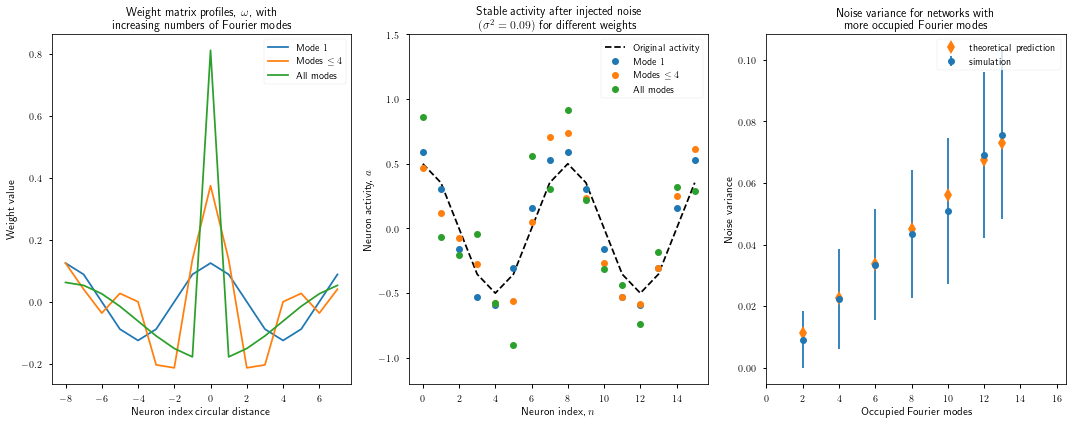

In [ ]:
dt=0.001

noisy_activity = a2 + noise_stddev*np.random.randn(*a.shape)
W_normal = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(2, 2, N)))
W_half = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(2, N//4, N)))
W_full = profile_to_matrix(get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(2, N//2, N)))

a_normal = noisy_activity.copy()
a_half = noisy_activity.copy()
a_full = noisy_activity.copy()
for _ in range(50000):
	a_normal += dt*(W_normal@a_normal - a_normal)
	a_half += dt*(W_half@a_half - a_half)
	a_full += dt*(W_full@a_full - a_full)

fig, axs = plt.subplots(1, 3, figsize=(15,6)) # paper figures should be width 10 (full linewidth)
axs[0].plot(neuron_indices-N//2, W_normal[N//2,:], label='Mode $1$')
axs[0].plot(neuron_indices-N//2, W_half[N//2,:], label=f'Modes $\\leq {N//4}$')
axs[0].plot(neuron_indices-N//2, W_full[N//2,:], label='All modes')
axs[0].set_xlabel('Neuron index circular distance')
axs[0].set_ylabel('Weight value')
axs[0].set_title('Weight matrix profiles, $\\omega$, with\nincreasing numbers of Fourier modes')
axs[0].legend()

axs[1].plot(neuron_indices, a2, 'k--', label='Original activity')
axs[1].plot(neuron_indices, a_normal, 'o', label='Mode $1$')
axs[1].plot(neuron_indices, a_half, 'o', label=f'Modes $\\leq {N//4}$')
axs[1].plot(neuron_indices, a_full, 'o', label=f'All modes')
axs[1].set_xlabel('Neuron index, $n$')
axs[1].set_ylabel('Neuron activity, $a$')
axs[1].set_title(f'Stable activity after injected noise\n$(\\sigma^2={noise_var})$ for different weights')
axs[1].set_ylim([-1.2,1.5])
axs[1].legend()

axs[2].errorbar(fourier_modes, fourier_mode_errors, fourier_mode_stddevs, fmt='o', label='simulation')
plt.plot(fourier_modes, noise_var/N*np.array(fourier_modes), 'd', markersize=10, label='theoretical prediction')
axs[2].set_xlabel('Occupied Fourier modes')
axs[2].set_ylabel('Noise variance')
axs[2].set_title(f'Noise variance for networks with\nmore occupied Fourier modes')
axs[2].set_xlim([0,N+0.5])
axs[2].legend()

plt.tight_layout()
# plt.savefig('plots/sinusoidal-noise-rejection-fourier-modes-negative-activity.pdf')
plt.show()

In [ ]:
print(f'x = {np.sum(a2 * np.cos(2*np.pi*neuron_indices/N))}')
print(f'y = {np.sum(a2 * np.sin(2*np.pi*neuron_indices/N))}')
print(f'theta = {180/np.pi*np.arctan2(np.sum(a2 * np.sin(2*np.pi*neuron_indices/N)), np.sum(a2 * np.cos(2*np.pi*neuron_indices/N)))}')

print(f'x = {np.sum(a_normal * np.cos(2*np.pi*neuron_indices/N))}')
print(f'y = {np.sum(a_normal * np.sin(2*np.pi*neuron_indices/N))}')
print(f'theta = {180/np.pi*np.arctan2(np.sum(a_normal * np.sin(2*np.pi*neuron_indices/N)), np.sum(a_normal * np.cos(2*np.pi*neuron_indices/N)))}')

print(f'x = {np.sum(a_half * np.cos(2*np.pi*neuron_indices/N))}')
print(f'y = {np.sum(a_half * np.sin(2*np.pi*neuron_indices/N))}')
print(f'theta = {180/np.pi*np.arctan2(np.sum(a_half * np.sin(2*np.pi*neuron_indices/N)), np.sum(a_half * np.cos(2*np.pi*neuron_indices/N)))}')

print(f'x = {np.sum(a_full * np.cos(2*np.pi*neuron_indices/N))}')
print(f'y = {np.sum(a_full * np.sin(2*np.pi*neuron_indices/N))}')
print(f'theta = {180/np.pi*np.arctan2(np.sum(a_full * np.sin(2*np.pi*neuron_indices/N)), np.sum(a_full * np.cos(2*np.pi*neuron_indices/N)))}')

x = -6.393148079866803e-16
y = -6.88168201664613e-16
theta = -132.89237931808168
x = 3.620726351994305
y = 0.8057725834371452
theta = 12.546400420864686
x = 3.6207263519943
y = 0.8057725834371956
theta = 12.546400420865462
x = 3.620726351994519
y = 0.8057725834370377
theta = 12.546400420862346


It looks like we don't change the decoding accuracy a lot by adding the high frequency noise, because it's zero mean?

0.22629539699964407
0.22629539699964374


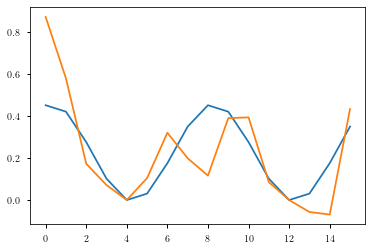

In [ ]:
# plt.plot(a * np.cos(2*np.pi*neuron_indices/N))
# plt.plot(a * np.sin(2*np.pi*neuron_indices/N))
x1 = a_normal * np.cos(2*np.pi*neuron_indices/N)
x2 = a_half * np.cos(2*np.pi*neuron_indices/N)
plt.plot(x1)
# plt.plot(a_normal * np.sin(2*np.pi*neuron_indices/N))
plt.plot(x2)
# plt.plot(a_half * np.sin(2*np.pi*neuron_indices/N))
print(f'{x1.mean()}')
print(f'{x2.mean()}')
# plt.plot(a_normal)
# plt.plot(a_half)

In [ ]:
a_normal - a_half

array([-0.42171754, -0.17220242,  0.14617617,  0.07976478,  0.00375171,
        0.19418011,  0.20526277, -0.1638043 , -0.33616382, -0.03351624,
        0.16676825, -0.0431609 , -0.11092362,  0.22933709,  0.34684608,
       -0.09059811])

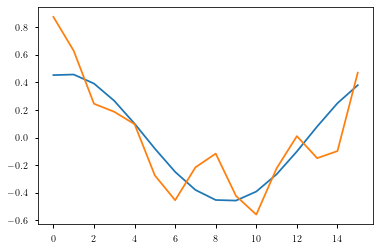

In [ ]:
plt.plot(a_normal)
plt.plot(a_half)

Fourier modes up to 1 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


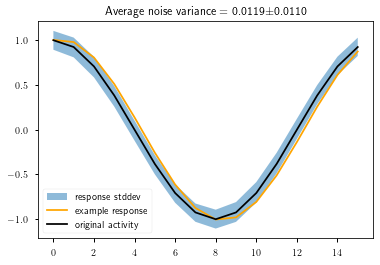

Fourier modes up to 2 = [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]


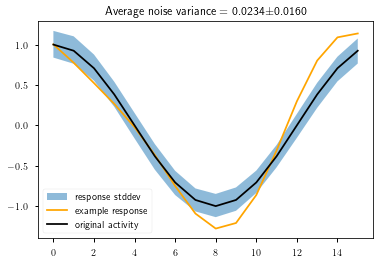

Fourier modes up to 3 = [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]


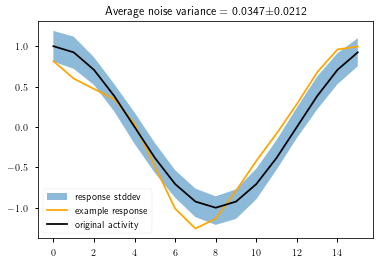

Fourier modes up to 4 = [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


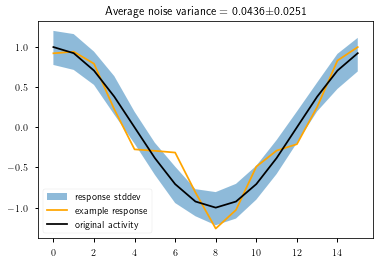

Fourier modes up to 5 = [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


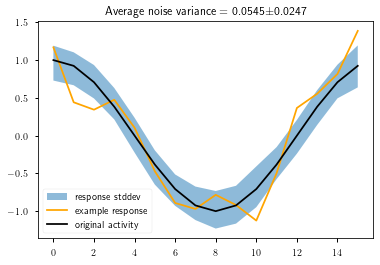

Fourier modes up to 6 = [0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]


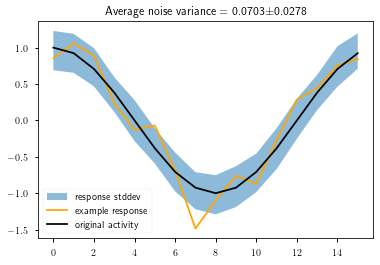

Fourier modes up to 7 = [0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.]


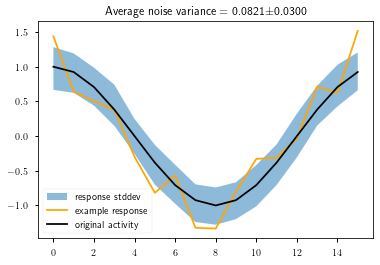

Fourier modes up to 8 = [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


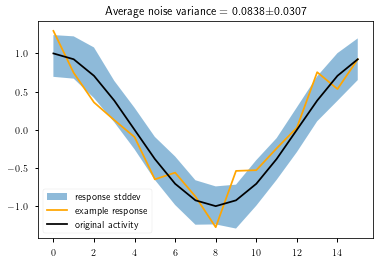

Fourier modes up to 2 = [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


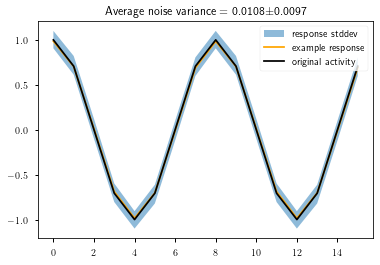

Fourier modes up to 3 = [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


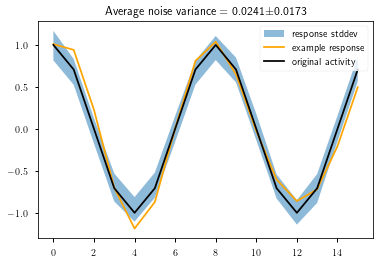

Fourier modes up to 4 = [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]


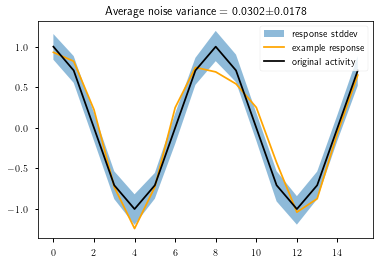

Fourier modes up to 5 = [0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.]


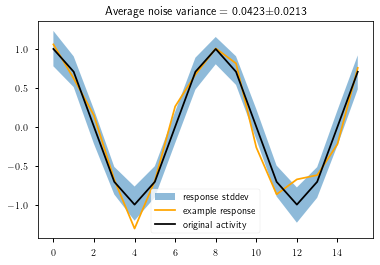

Fourier modes up to 6 = [0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.]


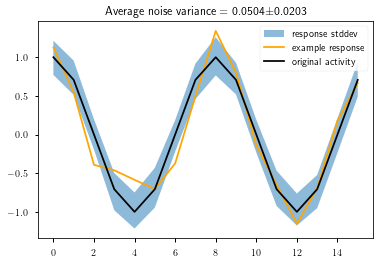

Fourier modes up to 7 = [0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0.]


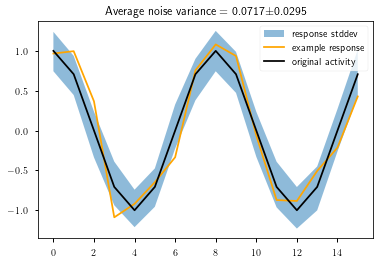

Fourier modes up to 8 = [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


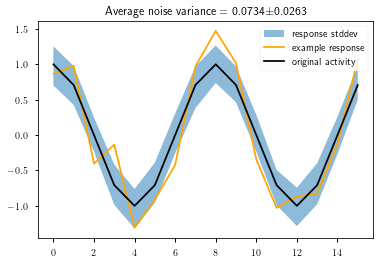

Fourier modes up to 3 = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


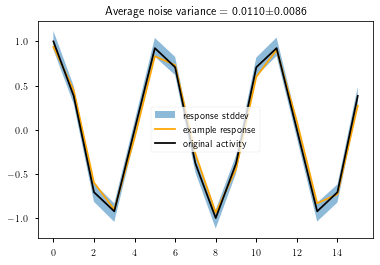

Fourier modes up to 4 = [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]


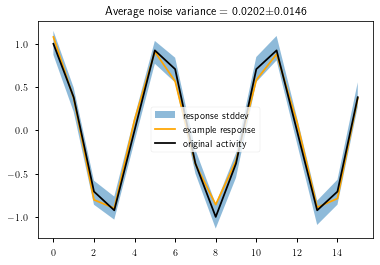

Fourier modes up to 5 = [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]


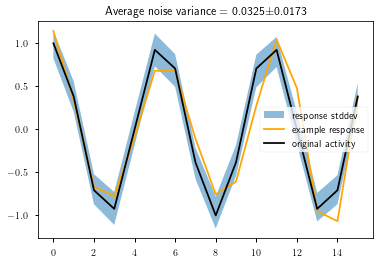

Fourier modes up to 6 = [0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0.]


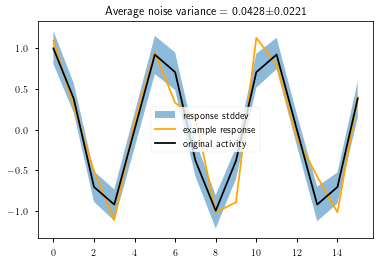

Fourier modes up to 7 = [0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0.]


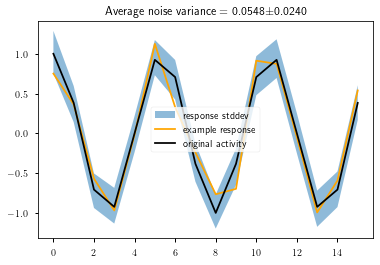

Fourier modes up to 8 = [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


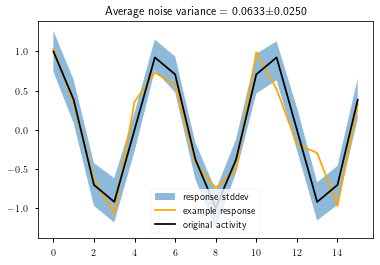

In [ ]:
fourier_mode_errors = []
fourier_mode_stddevs = []
fourier_modes = []
noise_stddev = 0.3
noise_var = noise_stddev**2

first_mode_range = np.arange(1,4)
for first_mode in first_mode_range:
	last_mode_range = np.arange(first_mode,N//2+1)
	a = np.cos(first_mode * 2*np.pi/N*neuron_indices)
	errors = []
	stddevs = []
	modes = []
	for last_mode in last_mode_range:
		fw = fill_fourier_modes_in_range(first_mode, last_mode, N)

		W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))

		print(f'Fourier modes up to {last_mode} = {fw}')
		ms_mean, ms_stddev = simulate_and_plot(a, W, noise=noise_stddev)
		errors.append(ms_mean)
		stddevs.append(ms_stddev)
		modes.append(fw.sum())
	fourier_mode_errors.append(errors)
	fourier_mode_stddevs.append(stddevs)
	fourier_modes.append(modes)

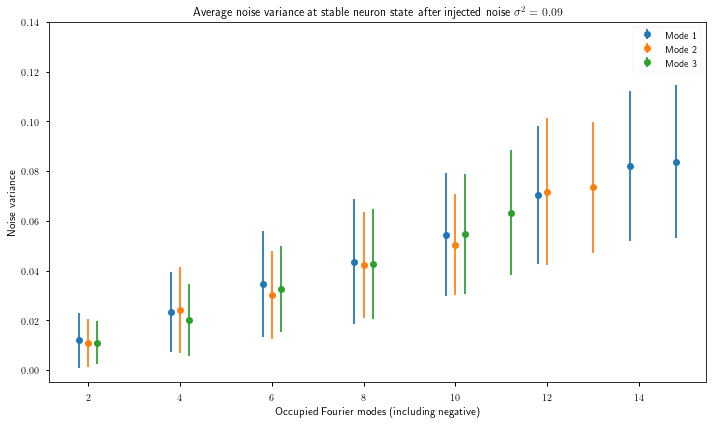

In [ ]:
plt.figure(figsize=(10,6))
for n, (errors, stddevs, modes) in enumerate(zip(fourier_mode_errors, fourier_mode_stddevs, fourier_modes)):
	plt.errorbar(np.array(modes)+0.2*(n-1), errors, stddevs, fmt='o')
plt.legend(['Mode 1', 'Mode 2', 'Mode 3'])
plt.xlabel('Occupied Fourier modes (including negative)')
plt.ylabel('Noise variance')
plt.title(f'Average noise variance at stable neuron state after injected noise $\\sigma^2={noise_var}$')
plt.ylim([-0.005, 0.14])
plt.tight_layout()
plt.show()

In [ ]:
decoded_angles = []
decoded_angles_stddevs = []
reps = 1000
noise_stddev = 0.3
noise_var = noise_stddev**2
dt=0.001

first_mode_range = np.arange(1,4)
for first_mode in first_mode_range:
	a0 = np.cos(first_mode * 2*np.pi/N*neuron_indices)
	fw = fill_fourier_modes_in_range(first_mode, first_mode, N)
	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))
	a = np.tile(a0, (reps,1)).T + noise_stddev*np.random.randn(a0.shape[0], reps)

	for _ in range(50000):
		a += dt*(W@a - a)
	
	decode_x = np.sum(a * np.atleast_2d(np.cos(first_mode * 2*np.pi/N*neuron_indices)).T, axis=0)
	decode_y = np.sum(a * np.atleast_2d(np.sin(first_mode * 2*np.pi/N*neuron_indices)).T, axis=0)
	decode_angle = np.arctan2(decode_y, decode_x)
	decoded_angles.append(decode_angle.mean())
	decoded_angles_stddevs.append(decode_angle.std())
decoded_angles = np.array(decoded_angles)
decoded_angles_stddevs = np.array(decoded_angles_stddevs)

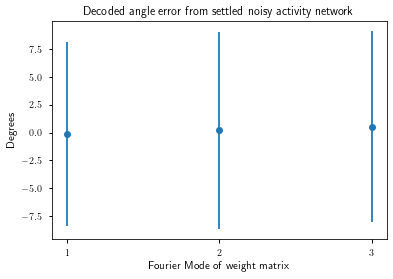

In [ ]:
plt.errorbar(first_mode_range, np.degrees(decoded_angles), np.degrees(decoded_angles_stddevs), fmt='o')
plt.title('Decoded angle error from settled noisy activity network')
plt.ylabel('Degrees')
plt.xlabel('Fourier Mode of weight matrix')
plt.xticks(first_mode_range)
plt.show()

So the standard deviation of the decoded angles is the same (~6 degrees) whether we use any one of the Fourier modes to do the encoding. But higher Fourier modes then have less range they can encode because of aliasing. Fourier mode 2 can only encode angles between 0 and 180 degrees. If we scale the decoding standard deviation relative to the range of angles that can be encoded, then the higher Fourier modes have more decoding error.

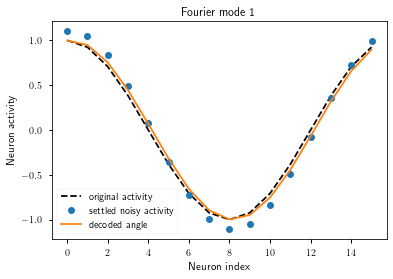

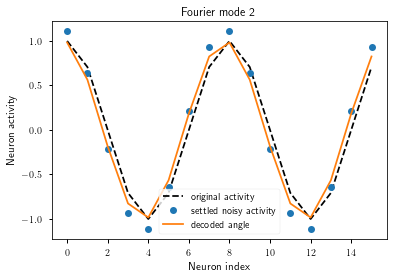

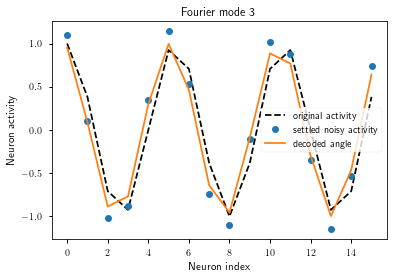

In [ ]:
reps = 1
noise_stddev = 0.5
noise_var = noise_stddev**2

first_mode_range = np.arange(1,4)
for first_mode in first_mode_range:
	a0 = np.cos(first_mode * 2*np.pi/N*neuron_indices)
	fw = fill_fourier_modes_in_range(first_mode, first_mode, N)
	W = profile_to_matrix(get_cosine_from_fourier_spectrum(fw))
	a = np.tile(a0, (reps,1)).T + noise_stddev*np.random.randn(a0.shape[0], reps)

	for _ in range(50000):
		a += dt*(W@a - a)
	
	decode_x = np.sum(a * np.atleast_2d(np.cos(first_mode * 2*np.pi/N*neuron_indices)).T, axis=0)
	decode_y = np.sum(a * np.atleast_2d(np.sin(first_mode * 2*np.pi/N*neuron_indices)).T, axis=0)
	decode_angle = np.arctan2(decode_y, decode_x)
	plt.figure()
	plt.plot(a0, 'k--', label='original activity')
	plt.plot(a, 'o', label='settled noisy activity')
	plt.plot(np.cos(first_mode * 2*np.pi/N*neuron_indices - decode_angle), label='decoded angle')
	plt.title(f'Fourier mode {first_mode}')
	plt.xlabel('Neuron index')
	plt.ylabel('Neuron activity')
	plt.legend()
	plt.show()